# Bitcoin and Gold: A fool's debate?

## Introduction
We are going to be looking at historic bitcoin and gold data, pretty much as far back as we can source them for (given the market has sufficient liquidity to warrant an analysis), and see whether we can draw any conclusions from the data.

## Data
We have sourced data as follows:
- Gold: daily price data for one troy ounce of Gold in USD was sourced from the World Gold Council (https://www.gold.org/goldhub/data/gold-prices) for the period ranging from 29 December 1978 to 3 February 2025.
- Bitcoin: daily prices where sourced from Coinbase (a large, long-standing, centralized spot exchange), via their API - one of the few ones that provide free data via their API - over the period 20 July 2015 (the first date for which Coinbase has a price, that we could retrieve), to 3 February 2025.

We believe that this is a sufficiently large dataset from which we can draw meaningful results.


In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# load gold prices and drop all columns except for price
gold_data = pd.read_csv('./data/gold_data.csv', dtype={'USD': 'float64'}, parse_dates=['Date'], date_format='%d-%b-%Y')
gold_data = gold_data[['Date', 'USD']]
gold_data.rename(columns={'USD': 'XAUUSD'}, inplace=True)

# load bitcoin prices and drop all columns except for time, closing price, and volume
btc_data = pd.read_csv('./data/btc_coinbase_prices.csv', dtype={'Close': 'float64', 'Volume': 'float64'}, parse_dates=['Time'],date_format='%d-%b-%Y')
btc_data = btc_data[['Time', 'Close', 'Volume']]
btc_data.rename(columns={'Time': 'Date', 'Close': 'BTCUSD'}, inplace=True)

# load bitcoin prices and drop all columns except for time, closing price, and volume
spx_data = pd.read_csv('./data/spx_prices.csv', dtype={'Close': 'float64'}, parse_dates=['Date'],date_format='%d-%b-%Y')
spx_data = spx_data[['Date', 'Close']]
spx_data.rename(columns={'Close': 'SPX'}, inplace=True)


## Analysis

We calculate daily log returns, which we are going to use for calculating realised volatilities on a given day as follows:
1. Annual realized volatility:
    - For Gold, use the last 252 business days of log returns (which corresponds to roughly a year), and calculate the standard deviation of these (which gives us a 1-day volatility). We then annualize this volatility by multiplying by the square root of 252.
    - For BTC, given that the market trades 365 days a year, we use the same method but use 365 days of log returns, and annualize the volatility by multiplying by sqrt(365).
2. Monthly realized volatility:
    - For Gold, we use the standard deviation of 21 business days of log returns (corresponding to a month) multiplied by sqrt(252).
    - For Bitcoin, we use the standard deviation of 30 days of log returns (corresponding to a month) multiplied by sqrt(30).

Volatility gives us an indication of the dispersion of the returns of an asset, i.e., how much they move around the mean. A higher volatility means that prices move around more, and that there is more uncertainty.

For each day in our analysis window, we calculate the realized volatility using the above formulae, yielding a timeseries of so-called rolling volatilities, showing how volatility changes over time.

In [23]:
# add daily return
gold_data['Daily_Log_Return'] = np.log(gold_data['XAUUSD'] / gold_data['XAUUSD'].shift(1))

# add realized volatilities
gold_data['Annual_RV'] = gold_data['Daily_Log_Return'].rolling(252).std() * np.sqrt(252)
gold_data['Monthly_RV'] = gold_data['Daily_Log_Return'].rolling(21).std() * np.sqrt(252)

# Set 'Date' as the DataFrame's index for resampling
gold_data = gold_data.set_index('Date')

# Resample gold_data weekly
gold_data = gold_data.resample('W').mean()

# Reset the index and format the 'Date' column to 'dd-MMM-yyyy'
gold_data = gold_data.reset_index()

# add daily return
btc_data['Daily_Log_Return'] = np.log(btc_data['BTCUSD'] / btc_data['BTCUSD'].shift(1))

# add realized volatilities
btc_data['Annual_RV'] = btc_data['Daily_Log_Return'].rolling(365).std() * np.sqrt(365)
btc_data['Monthly_RV'] = btc_data['Daily_Log_Return'].rolling(30).std() * np.sqrt(365)


# add daily return
spx_data['Daily_Log_Return'] = np.log(spx_data['SPX'] / spx_data['SPX'].shift(1))

# add realized volatilities
spx_data['Annual_RV'] = spx_data['Daily_Log_Return'].rolling(252).std() * np.sqrt(252)
spx_data['Monthly_RV'] = spx_data['Daily_Log_Return'].rolling(21).std() * np.sqrt(252)

Let's plot the timeseries of prices of gold and bitcoin, and their respective realized volatilites.

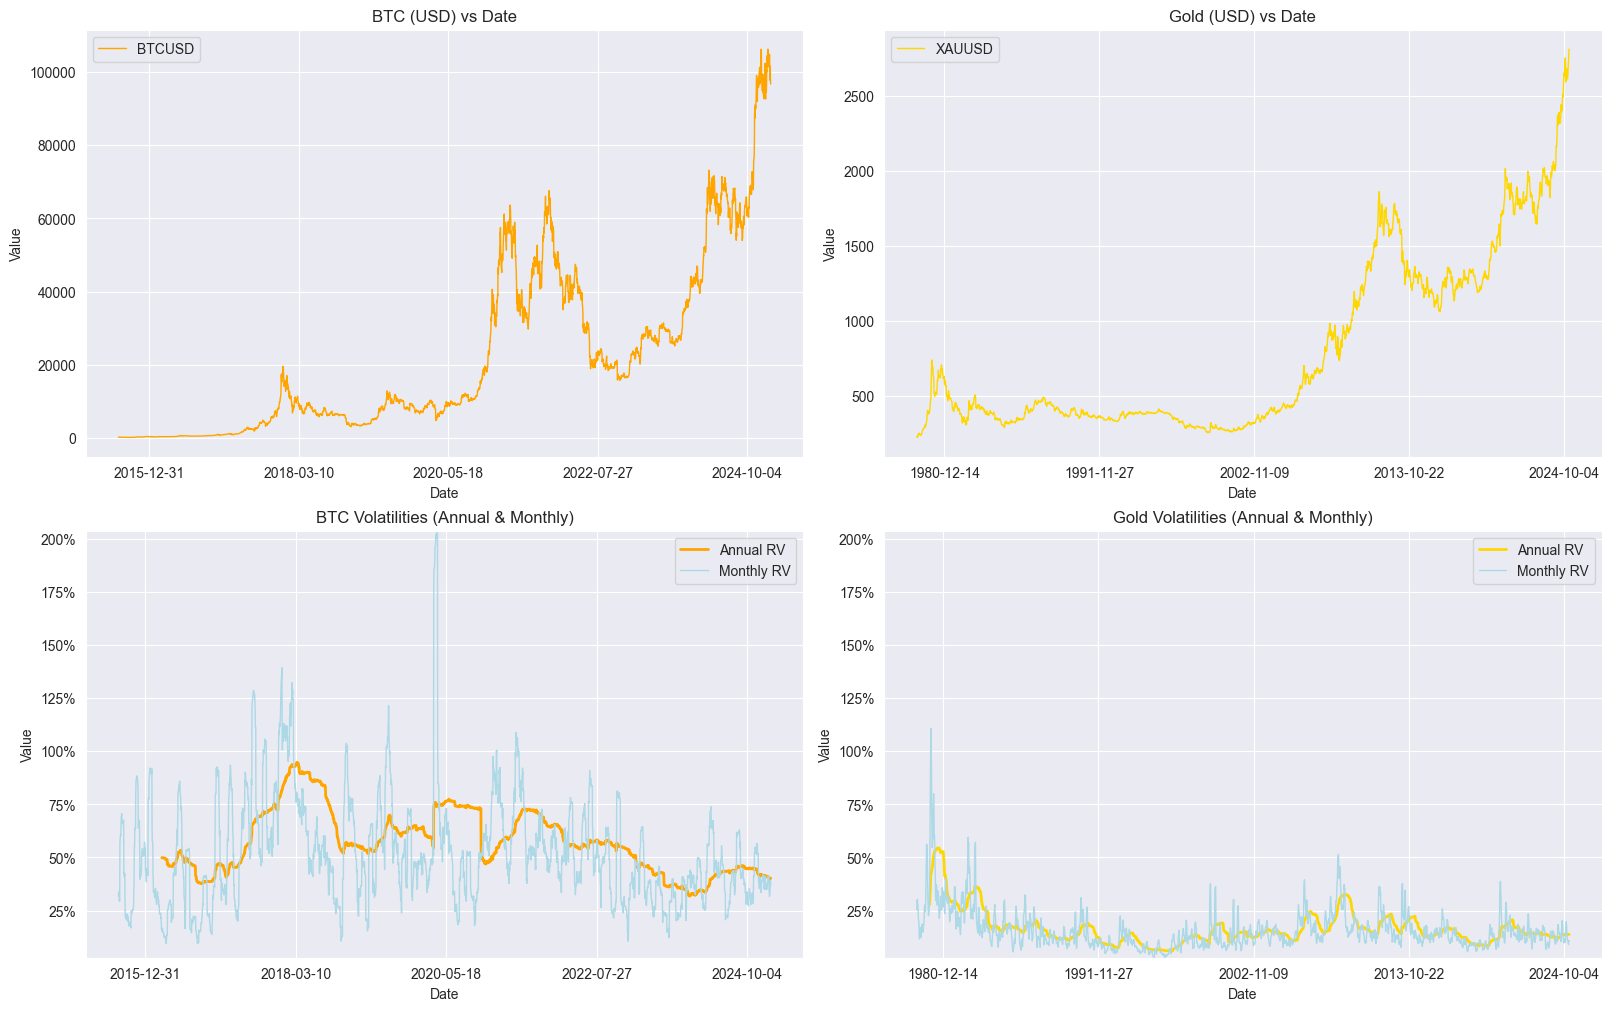

In [26]:
# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10), constrained_layout=True)  # Adjusted layout for better spacing

# Plot BTCUSD and XAUUSD against Date in the first row
sns.lineplot(ax=axes[0, 0], data=btc_data, x='Date', y='BTCUSD', label='BTCUSD', color='orange', linewidth=1)
sns.lineplot(ax=axes[0, 1], data=gold_data, x='Date', y='XAUUSD', label='XAUUSD', color='gold', linewidth=1)

# Titles for the first row
axes[0, 0].set_title('BTC (USD) vs Date')
axes[0, 1].set_title('Gold (USD) vs Date')

# Plot Annual_RV and Monthly_RV for btc_data in the second row, first column
sns.lineplot(ax=axes[1, 0], data=btc_data, x='Date', y='Annual_RV', label='Annual RV', color='orange', linewidth=2)
sns.lineplot(ax=axes[1, 0], data=btc_data, x='Date', y='Monthly_RV', label='Monthly RV', color='lightblue', linewidth=1)
axes[1, 0].set_title('BTC Volatilities (Annual & Monthly)')

# Plot Annual_RV and Monthly_RV for gold_data in the second row, second column
sns.lineplot(ax=axes[1, 1], data=gold_data, x='Date', y='Annual_RV', label='Annual RV', color='gold', linewidth=2)
sns.lineplot(ax=axes[1, 1], data=gold_data, x='Date', y='Monthly_RV', label='Monthly RV', color='lightblue', linewidth=1)
axes[1, 1].set_title('Gold Volatilities (Annual & Monthly)')

# Set the same y-axis limits for the second row's plots
min_y = min(btc_data[['Annual_RV', 'Monthly_RV']].min().min(), gold_data[['Annual_RV', 'Monthly_RV']].min().min())
max_y = max(btc_data[['Annual_RV', 'Monthly_RV']].max().max(), gold_data[['Annual_RV', 'Monthly_RV']].max().max())
axes[1, 0].set_ylim(min_y, max_y)
axes[1, 1].set_ylim(min_y, max_y)

# Add legends, improve axis labels and make x-axis sparse
for ax in axes.flatten():
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))  # Reduce the number of x-axis ticks for sparsity

# Show the second row's y-axis as percentages
for ax in axes[1, :]:
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

# Show the complete grid plot
plt.show()



Let's consider what we are looking at.